# Quantifying the multiple loci editing efficiency of multitron editing platform

### Import packages

In [1]:
import sys,os, glob
import shutil

import matplotlib.pyplot as plt
plt.rcParams['pdf.fonttype'] = 42

import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'

import seaborn as sns

from Bio import SeqIO
import fuzzysearch
import re
from collections import Counter, OrderedDict
from Bio.Seq import Seq

/Users/slopez/opt/anaconda3/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [11]:
run = 'change/to/dir'

os.chdir(run)

### load dataframe of sample ID and conditions 

In [14]:
samples = pd.read_excel("samples.xlsx")[["sample_name", "Description", "Sub-Library Owner"]]
samples

,sample_name,Description,Sub-Library Owner
0,msMRM_9_07,hek_cas9 +757 EMX1 R1,SCL
1,msMRM_9_08,hek_cas9 +757 EMX1 R2,SCL
2,msMRM_9_09,hek_cas9 +757 EMX1 R3,SCL
3,msMRM_9_10,hek_cas9 +758 EMX1 R1,SCL
4,msMRM_9_11,hek_cas9 +758 EMX1 R2,SCL
5,msMRM_9_12,hek_cas9 +758 EMX1 R3,SCL
6,msMRM_9_13,hek_cas9 +758 FANCF R1,SCL
7,msMRM_9_14,hek_cas9 +760 EMX1 R2,SCL
8,msMRM_9_15,hek_cas9 +760 EMX1 R3,SCL
9,msMRM_9_16,hek_cas9 +763 EMX1 R1,SCL


### define env

In [16]:
print ("="*60)
for file in glob.glob("ms*"):
    fn = file.split("_L001")[0]
    condition = samples["Description"][samples["sample_name"]==fn].to_string(index=False)
    owner = samples["Sub-Library Owner"][samples["sample_name"]==fn].to_string(index=False)
    
    if "SCL" in owner:
        print (fn + " -- " + condition)
        os.chdir(file)
        r1 = glob.glob("*R1_001*")[0]
        print (r1)
        print ("\ntrimming files\n")
        cmd = "sickle se -f {0} -t sanger \
                -o trimmed_R1.fastq".format(r1)
        os.system(cmd)    
        print ("="*60)

        os.chdir(run)
        
    else:
        pass
os.chdir(run)

msMRM_9_16 -- hek_cas9 +763 EMX1 R1
msMRM-9-16_S16_L001_R1_001.fastq.gz

trimming files


FastQ records kept: 52844
FastQ records discarded: 11

msMRM_9_17 -- hek_cas9 +763 EMX1 R2
msMRM-9-17_S17_L001_R1_001.fastq.gz

trimming files


FastQ records kept: 684259
FastQ records discarded: 70

msMRM_9_07 -- hek_cas9 +757 EMX1 R1
msMRM-9-07_S7_L001_R1_001.fastq.gz

trimming files


FastQ records kept: 44017
FastQ records discarded: 3

msMRM_9_20 -- hek_cas9 +766 EMX1 R2
msMRM-9-20_S20_L001_R1_001.fastq.gz

trimming files


FastQ records kept: 80220
FastQ records discarded: 10

msMRM_9_18 -- hek_cas9 +763 EMX1 R3
msMRM-9-18_S18_L001_R1_001.fastq.gz

trimming files


FastQ records kept: 72290
FastQ records discarded: 8

msMRM_9_09 -- hek_cas9 +757 EMX1 R3
msMRM-9-09_S9_L001_R1_001.fastq.gz

trimming files


FastQ records kept: 62056
FastQ records discarded: 11

msMRM_9_11 -- hek_cas9 +758 EMX1 R2
msMRM-9-11_S11_L001_R1_001.fastq.gz

trimming files


FastQ records kept: 50596
FastQ records dis

### parse files and pull indel profile

In [18]:
# define genomic region of interest
# EMX1, FANCF, HEK3

Region_dict = {'EMX1': {'flanking': ['AGGGCCTGAGTCCGAGCAGA','ATCACATCAACCGGTGGCGC'], 'wt_or_edited': ['AGAAGAAGGGCTCCC','AGAAAAAGTTCTCCC']},
                                            # 20bp               20bp                                      15bp            15bp
               'FANCF': {'flanking': ['ACCTCATGGAATCCCTTCTG','TTTTCCGAGCTTCTGGCGGT'], 'wt_or_edited': ['CAGCACCTGGATCGC','CAGCATCTAGATCGC']},
               'HEK3': {'flanking': ['TCCTTGGGGCCCAGACTGAG','GAAAGGAAGCCCTGCTTCCT'], 'wt_or_edited': ['CACGTGATGGCAGAG','CACGTGCTAACAGAG']},
              }

def extract_and_exact_match(sequence, edit_site):
    left_flank = fuzzysearch.find_near_matches(Region_dict[edit_site]['flanking'][0],sequence,max_l_dist=3)
    right_flank = fuzzysearch.find_near_matches(Region_dict[edit_site]['flanking'][1],sequence,max_l_dist=3)
    if len(left_flank) == 1 and len(right_flank) == 1:
        region = sequence[left_flank[0].end:right_flank[0].start]
        if region == Region_dict[edit_site]['wt_or_edited'][0]:
            return ('wt', region)
        elif region == Region_dict[edit_site]['wt_or_edited'][1]:
            return ('edited', region)
        else: return ('undetermined_no_site_match', region)
    else:
        return ('undetermined_no_flanking_match', None)

In [19]:
os.chdir(run)

df_exact_files = pd.DataFrame(columns=["sample_name", "condition", "wt", "edited",
                                 "undetermined_no_flanking_match", 'undetermined_no_site_match',
                                 "total reads", "edited_percent"])
fastq_reads = "trimmed_R1.fastq"
print ("="*60)

all_data = {}
for file in glob.glob("ms*"):
    fn = file.split("_L001")[0]
    condition = samples["Description"][samples["sample_name"]==fn].to_string(index=False)
    
    if "hek_cas9" in condition:
        
        all_data[condition] = {}
        
        npe = []
        all_reads_str = []
        print (fn + " -- " + condition)
        os.chdir(file)

        filename = glob.glob("*.fastq.gz")


        for seq_record in SeqIO.parse(fastq_reads, "fastq"):
            all_reads_str.append(str(seq_record.seq))
        read_counter = Counter(all_reads_str)

        for site in Region_dict.keys():
            if site in condition:
                outcomes_dict = {'wt':0,
                                 'edited':0,
                                 'undetermined_no_flanking_match':0,
                                 'undetermined_no_site_match':0}
                edit_site = site

                for read in read_counter:
                    if extract_and_exact_match(read, edit_site)[0]=='undetermined_no_site_match':
                        npe.extend([extract_and_exact_match(read, edit_site)[1]]*read_counter[read])
                    outcomes_dict[extract_and_exact_match(read, edit_site)[0]] += read_counter[read] 
                try:
                    edited_percent = (float(outcomes_dict['edited'])/float(outcomes_dict['edited']+outcomes_dict['wt']))*100
                except:
                    edited_percent = 0
                all_data[condition][site] = outcomes_dict
            
    os.chdir(run)


msMRM_9_16 -- hek_cas9 +763 EMX1 R1
msMRM_9_17 -- hek_cas9 +763 EMX1 R2
msMRM_9_07 -- hek_cas9 +757 EMX1 R1
msMRM_9_20 -- hek_cas9 +766 EMX1 R2
msMRM_9_18 -- hek_cas9 +763 EMX1 R3
msMRM_9_09 -- hek_cas9 +757 EMX1 R3
msMRM_9_11 -- hek_cas9 +758 EMX1 R2
msMRM_9_21 -- hek_cas9 +758 HEK3 R3
msMRM_9_14 -- hek_cas9 +760 EMX1 R2
msMRM_9_15 -- hek_cas9 +760 EMX1 R3
msMRM_9_13 -- hek_cas9 +758 FANCF R1
msMRM_9_08 -- hek_cas9 +757 EMX1 R2
msDMP_02_182 -- hek_cas9 +758 HEK3 R2
msMRM_9_12 -- hek_cas9 +758 EMX1 R3
msDMP_02_183 -- hek_cas9 +760 EMX1 R3
msMRM_9_10 -- hek_cas9 +758 EMX1 R1
msDMP_02_181 -- hek_cas9 +758 HEK3 R1
msMRM_9_19 -- hek_cas9 +766 EMX1 R1
msDMP_02_179 -- hek_cas9 +758 FANCF R2
msDMP_02_180 -- hek_cas9 +758 FANCF R3


In [20]:
all_counts_df = pd.DataFrame.from_dict(all_data, orient = 'index').stack().apply(pd.Series).unstack()
display(all_counts_df)

wt                     edited                 \
                            EMX1     HEK3     FANCF    EMX1    HEK3  FANCF   
hek_cas9 +763 EMX1 R1    43249.0      NaN       NaN   542.0     NaN    NaN   
hek_cas9 +763 EMX1 R2   544410.0      NaN       NaN  7263.0     NaN    NaN   
hek_cas9 +757 EMX1 R1    29738.0      NaN       NaN  1039.0     NaN    NaN   
hek_cas9 +766 EMX1 R2    64302.0      NaN       NaN     7.0     NaN    NaN   
hek_cas9 +763 EMX1 R3    57359.0      NaN       NaN   847.0     NaN    NaN   
hek_cas9 +757 EMX1 R3    39156.0      NaN       NaN  1549.0     NaN    NaN   
hek_cas9 +758 EMX1 R2    29843.0      NaN       NaN   206.0     NaN    NaN   
hek_cas9 +760 EMX1 R2    24078.0      NaN       NaN     6.0     NaN    NaN   
hek_cas9 +760 EMX1 R3    66835.0      NaN       NaN    48.0     NaN    NaN   
hek_cas9 +757 EMX1 R2    48865.0      NaN       NaN  1710.0     NaN    NaN   
hek_cas9 +758 EMX1 R3    45584.0      NaN       NaN   268.0     NaN    NaN   
hek_cas9 +758 EMX1 R1    23481.0      NaN       NaN   147.0     NaN    NaN   
hek_cas9 +766 EMX1 R1    52834.0      NaN       NaN     9.0     NaN    NaN   
hek_cas9 +758 HEK3 R3        NaN  25807.0       NaN     NaN   465.0    NaN   
hek_cas9 +758 HEK3 R2        NaN  79056.0       NaN     NaN  1492.0    NaN   
hek_cas9 +758 HEK3 R1        NaN  81076.0       NaN     NaN  1564.0    NaN   
hek_cas9 +758 FANCF R1       NaN      NaN   28523.0     NaN     NaN   76.0   
hek_cas9 +758 FANCF R2       NaN      NaN  119181.0     NaN     NaN  231.0   
hek_cas9 +758 FANCF R3       NaN      NaN   79571.0     NaN     NaN  161.0   

                       undetermined_no_flanking_match                     \
                                                 EMX1     HEK3     FANCF   
hek_cas9 +763 EMX1 R1                          6737.0      NaN       NaN   
hek_cas9 +763 EMX1 R2                        100938.0      NaN       NaN   
hek_cas9 +757 EMX1 R1                          8557.0      NaN       NaN   
hek_cas9 +766 EMX1 R2                         13159.0      NaN       NaN   
hek_cas9 +763 EMX1 R3                         10707.0      NaN       NaN   
hek_cas9 +757 EMX1 R3                         14734.0      NaN       NaN   
hek_cas9 +758 EMX1 R2                         11556.0      NaN       NaN   
hek_cas9 +760 EMX1 R2                          7273.0      NaN       NaN   
hek_cas9 +760 EMX1 R3                         65125.0      NaN       NaN   
hek_cas9 +757 EMX1 R2                         14191.0      NaN       NaN   
hek_cas9 +758 EMX1 R3                         24727.0      NaN       NaN   
hek_cas9 +758 EMX1 R1                          8428.0      NaN       NaN   
hek_cas9 +766 EMX1 R1                         10337.0      NaN       NaN   
hek_cas9 +758 HEK3 R3                             NaN   3632.0       NaN   
hek_cas9 +758 HEK3 R2                             NaN  15181.0       NaN   
hek_cas9 +758 HEK3 R1                             NaN  17101.0       NaN   
hek_cas9 +758 FANCF R1                            NaN      NaN   23794.0   
hek_cas9 +758 FANCF R2                            NaN      NaN  125649.0   
hek_cas9 +758 FANCF R3                            NaN      NaN   85427.0   

                       undetermined_no_site_match                   
                                             EMX1     HEK3   FANCF  
hek_cas9 +763 EMX1 R1                      2316.0      NaN     NaN  
hek_cas9 +763 EMX1 R2                     31648.0      NaN     NaN  
hek_cas9 +757 EMX1 R1                      4683.0      NaN     NaN  
hek_cas9 +766 EMX1 R2                      2752.0      NaN     NaN  
hek_cas9 +763 EMX1 R3                      3377.0      NaN     NaN  
hek_cas9 +757 EMX1 R3                      6617.0      NaN     NaN  
hek_cas9 +758 EMX1 R2                      8991.0      NaN     NaN  
hek_cas9 +760 EMX1 R2                      3528.0      NaN     NaN  
hek_cas9 +760 EMX1 R3                      9843.0      NaN     NaN  
hek_cas9 +757 EMX1 R2              

In [49]:
pct_edit_df = pd.DataFrame()

for site in Region_dict:
    pct_edit_df["edited_pct_"+site] = 100.0 * all_counts_df.iloc[:, all_counts_df.columns.get_level_values(1)==site]["edited"] / (all_counts_df.iloc[:, all_counts_df.columns.get_level_values(1)==site]["edited"]+all_counts_df.iloc[:, all_counts_df.columns.get_level_values(1)==site]["wt"] +all_counts_df.iloc[:, all_counts_df.columns.get_level_values(1)==site]["undetermined_no_site_match"])

In [50]:
pct_edit_df = pct_edit_df.reset_index().rename(columns={'index':'sample'})

In [51]:
pct_edit_df

,sample,edited_pct_EMX1,edited_pct_FANCF,edited_pct_HEK3
0,hek_cas9 +763 EMX1 R1,1.175526,NaN,NaN
1,hek_cas9 +763 EMX1 R2,1.245112,NaN,NaN
2,hek_cas9 +757 EMX1 R1,2.930062,NaN,NaN
3,hek_cas9 +766 EMX1 R2,0.010438,NaN,NaN
4,hek_cas9 +763 EMX1 R3,1.375380,NaN,NaN
5,hek_cas9 +757 EMX1 R3,3.273319,NaN,NaN
6,hek_cas9 +758 EMX1 R2,0.527664,NaN,NaN
7,hek_cas9 +760 EMX1 R2,0.021730,NaN,NaN
8,hek_cas9 +760 EMX1 R3,0.062560,NaN,NaN
9,hek_cas9 +757 EMX1 R2,2.950565,NaN,NaN


In [52]:
pct_edit_df[["strain", "editor", "site", "replicate"]] = pct_edit_df["sample"].str.split(" ", n=4, expand = True)

e = {"+757": "EMX1 (hCtRNA)",
     "+758": "EMX1/FANCF/HEK3 (hCtRNA)",
     "+760": "EMX1 (hCtRNA dRT)",
     "+763": "EMX1 (hCtRNA-M)",
     "+766": "EMX1 (hCtRNA-M dRT)",
    }

pct_edit_df["target_site"] = pct_edit_df["editor"].map(e)
pct_edit_df = pct_edit_df.drop("sample", axis=1)

In [53]:
pct_edit_df

,edited_pct_EMX1,edited_pct_FANCF,edited_pct_HEK3,strain,editor,site,replicate,target_site
0,1.175526,NaN,NaN,hek_cas9,+763,EMX1,R1,EMX1 (hCtRNA-M)
1,1.245112,NaN,NaN,hek_cas9,+763,EMX1,R2,EMX1 (hCtRNA-M)
2,2.930062,NaN,NaN,hek_cas9,+757,EMX1,R1,EMX1 (hCtRNA)
3,0.010438,NaN,NaN,hek_cas9,+766,EMX1,R2,EMX1 (hCtRNA-M dRT)
4,1.375380,NaN,NaN,hek_cas9,+763,EMX1,R3,EMX1 (hCtRNA-M)
5,3.273319,NaN,NaN,hek_cas9,+757,EMX1,R3,EMX1 (hCtRNA)
6,0.527664,NaN,NaN,hek_cas9,+758,EMX1,R2,EMX1/FANCF/HEK3 (hCtRNA)
7,0.021730,NaN,NaN,hek_cas9,+760,EMX1,R2,EMX1 (hCtRNA dRT)
8,0.062560,NaN,NaN,hek_cas9,+760,EMX1,R3,EMX1 (hCtRNA dRT)
9,2.950565,NaN,NaN,hek_cas9,+757,EMX1,R2,EMX1 (hCtRNA)


In [54]:
pct_edit_df = pct_edit_df[~pct_edit_df['target_site'].str.contains('-M')]

In [57]:
pct_edit_df

,edited_pct_EMX1,edited_pct_FANCF,edited_pct_HEK3,strain,editor,site,replicate,target_site
2,2.930062,NaN,NaN,hek_cas9,+757,EMX1,R1,EMX1 (hCtRNA)
5,3.273319,NaN,NaN,hek_cas9,+757,EMX1,R3,EMX1 (hCtRNA)
6,0.527664,NaN,NaN,hek_cas9,+758,EMX1,R2,EMX1/FANCF/HEK3 (hCtRNA)
7,0.021730,NaN,NaN,hek_cas9,+760,EMX1,R2,EMX1 (hCtRNA dRT)
8,0.062560,NaN,NaN,hek_cas9,+760,EMX1,R3,EMX1 (hCtRNA dRT)
9,2.950565,NaN,NaN,hek_cas9,+757,EMX1,R2,EMX1 (hCtRNA)
10,0.445523,NaN,NaN,hek_cas9,+758,EMX1,R3,EMX1/FANCF/HEK3 (hCtRNA)
11,0.475359,NaN,NaN,hek_cas9,+758,EMX1,R1,EMX1/FANCF/HEK3 (hCtRNA)
13,NaN,NaN,0.958229,hek_cas9,+758,HEK3,R3,EMX1/FANCF/HEK3 (hCtRNA)
14,NaN,NaN,0.970211,hek_cas9,+758,HEK3,R2,EMX1/FANCF/HEK3 (hCtRNA)


In [59]:
pct_edit_df = pct_edit_df.melt(
                            id_vars = ['strain', 'editor', 'replicate', 'site', 'target_site'],
                            var_name="site_edited", 
                            value_name="precise_editing_rate").rename(columns={"target_site":"plasmid-carried editors",
                                                                               })

In [60]:
pct_edit_df.tail(50)

,strain,editor,replicate,site,plasmid-carried editors,site_edited,precise_editing_rate
0,hek_cas9,+757,R1,EMX1,EMX1 (hCtRNA),edited_pct_EMX1,2.930062
1,hek_cas9,+757,R3,EMX1,EMX1 (hCtRNA),edited_pct_EMX1,3.273319
2,hek_cas9,+758,R2,EMX1,EMX1/FANCF/HEK3 (hCtRNA),edited_pct_EMX1,0.527664
3,hek_cas9,+760,R2,EMX1,EMX1 (hCtRNA dRT),edited_pct_EMX1,0.021730
4,hek_cas9,+760,R3,EMX1,EMX1 (hCtRNA dRT),edited_pct_EMX1,0.062560
5,hek_cas9,+757,R2,EMX1,EMX1 (hCtRNA),edited_pct_EMX1,2.950565
6,hek_cas9,+758,R3,EMX1,EMX1/FANCF/HEK3 (hCtRNA),edited_pct_EMX1,0.445523
7,hek_cas9,+758,R1,EMX1,EMX1/FANCF/HEK3 (hCtRNA),edited_pct_EMX1,0.475359
8,hek_cas9,+758,R3,HEK3,EMX1/FANCF/HEK3 (hCtRNA),edited_pct_EMX1,NaN
9,hek_cas9,+758,R2,HEK3,EMX1/FANCF/HEK3 (hCtRNA),edited_pct_EMX1,NaN


In [61]:
df_endog = pct_edit_df

In [62]:
df_endog = df_endog.sort_values(['strain', 'editor', 'plasmid-carried editors', 'replicate',])
df_endog.to_csv('human_mpx_data_29042024.csv',)

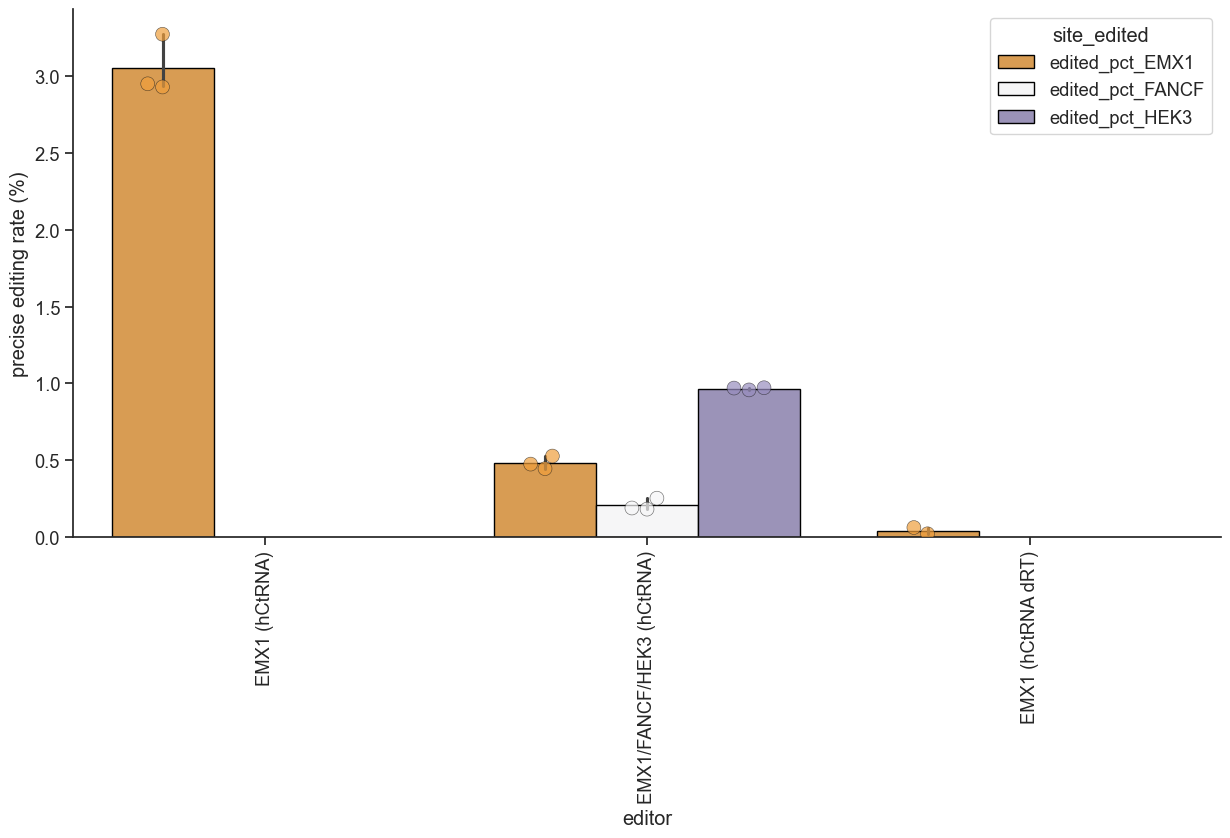

In [68]:
sns.set(font_scale = 1.2)
sns.set_style("ticks")

g = sns.catplot(x='plasmid-carried editors', y='precise_editing_rate', hue = 'site_edited',
    data=df_endog, dodge = True,
    height= 6.27, aspect=2, kind="swarm", fc='none', edgecolor='k',linewidth=0.4, s=100, alpha = 0.7,
    palette= "PuOr", legend = False)


sns.barplot(x='plasmid-carried editors', y='precise_editing_rate', hue = 'site_edited',
    data=df_endog, dodge = True, 
    palette= "PuOr", edgecolor='black')
g.set(xlabel='editor', ylabel='precise editing rate (%)', )

g.set_xticklabels(rotation=90)

g.savefig("human_multiplexing_29042024.pdf")

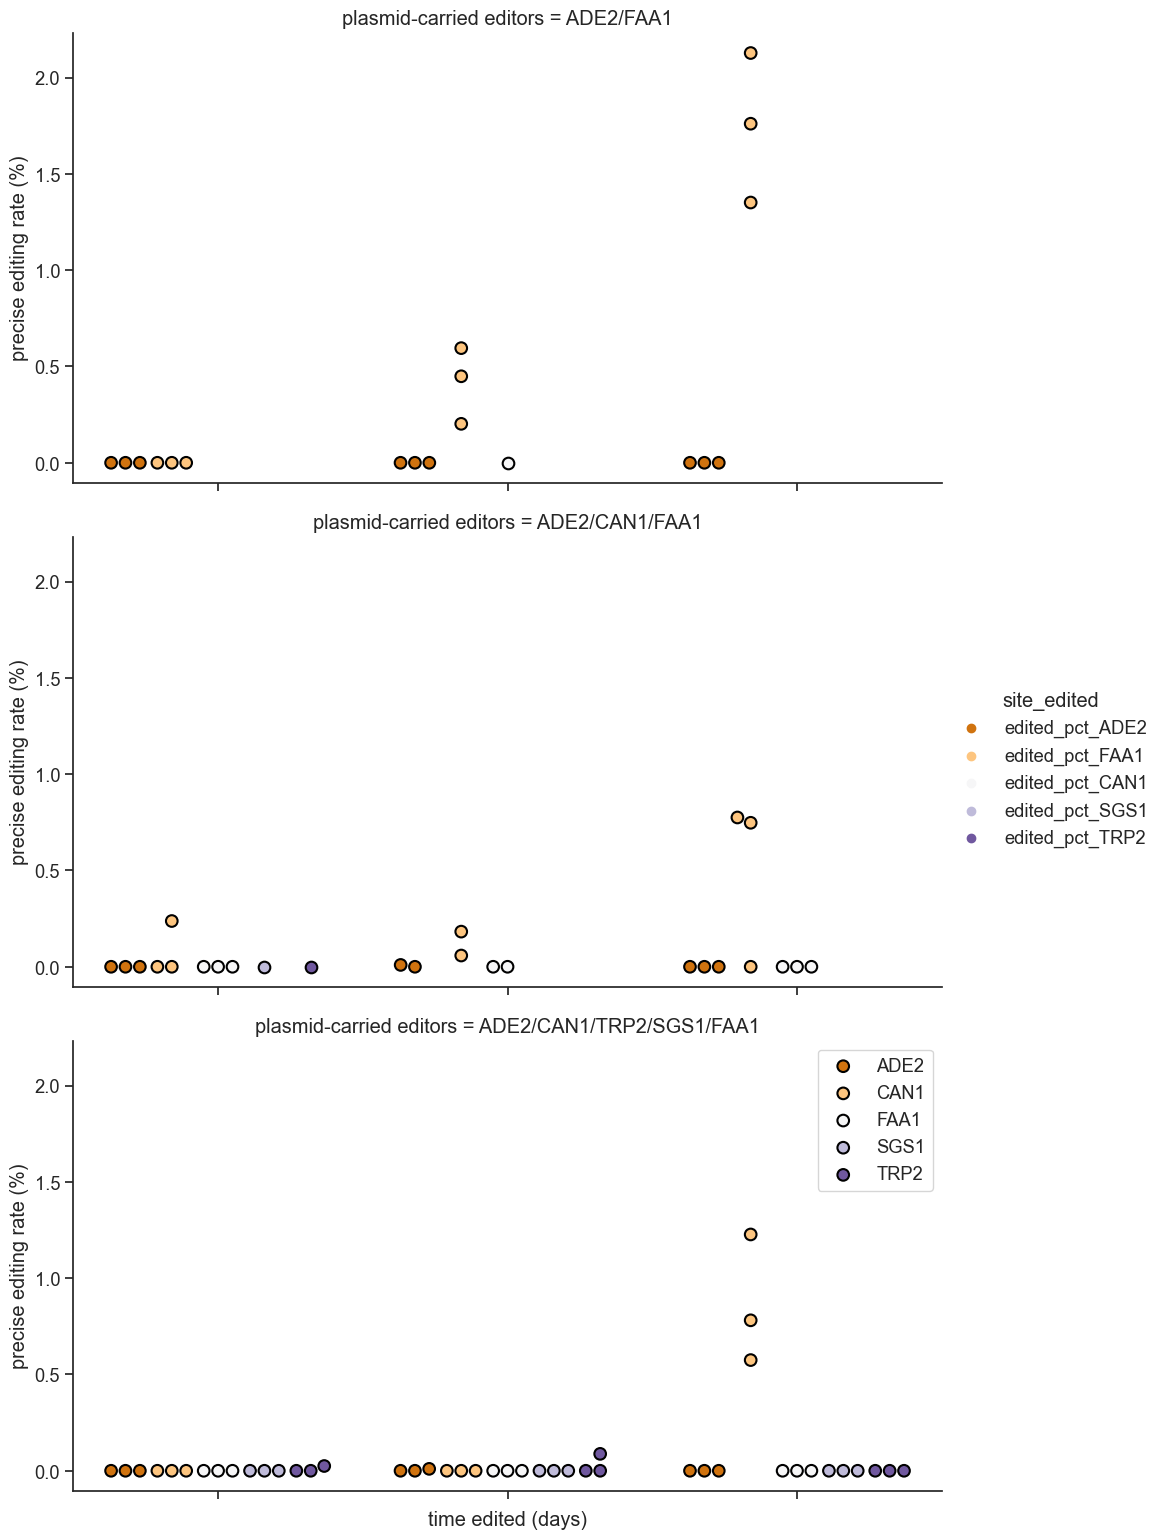

In [30]:
sns.set(font_scale = 1.2)
sns.set_style("ticks")


g = sns.catplot(x="time", y='precise_editing_rate', hue = 'site_edited', col='plasmid-carried editors', col_wrap = 1,
                hue_order = ['edited_pct_ADE2', 'edited_pct_FAA1', 'edited_pct_CAN1','edited_pct_SGS1','edited_pct_TRP2'],
    data=df_endog_control, dodge = True,
    height=5.27, aspect=11.7/6.27, kind="swarm", s=70, edgecolor='black', linewidth=1.5,
    palette= "PuOr", legend = True)

g.set(xlabel='time edited (days)', ylabel='precise editing rate (%)',)
plt.legend(labels=['ADE2', 
                    'CAN1',
                    'FAA1',
                    'SGS1',
                    'TRP2'])
g.set_xticklabels(rotation=90)

g.savefig("yeast_multiplexing_endog_control_23062023.pdf")